In [1]:
#!/usr/bin/env python
#-*- coding: utf-8 -*-
'''
    python ==> MNIST 데이터를 불러와 25번 학습한 후 정답을 맞히는 코드
'''
import os
import random 
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import urllib
import gzip
import matplotlib.pyplot as plt


SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'

def maybe_download(filename, work_directory):
	if not os.path.exists(work_directory):
		os.mkdir(work_directory)

	filepath = os.path.join(work_directory, filename)

	if not os.path.exists(filepath):
		filepath, _ = urllib.urlretrieve(SOURCE_URL + filename, fileapath)
		statinfo = os.stat(filepath)
		print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
	return filepath


def _read32(bytestream):
	dt = numpy.dtype(numpy.uint32).newbyteorder('>')
	return numpy.frombuffer(bytestream.read(4), dtype =dt)


def extract_imagess(filename):
	print('Extracintg', filename)

	with gzip.open(filename) as bytestream:
		magic = _read32(bytestream)
		if magic != 2051:
			raise ValueError(
				'Invalid magic number %d in MNIST image file: %s' % (magic,filename))
		num_images = _read32(bytestream)
		rows = _read32(bytestream)
		cols = _read32(bytestream)
		buf = bytestream.read(rows * cols * num_images)
		data = numpy.frombuffer(buf, dtype=numpy.uint8)

def dense_to_one_hot(labels_dense, num_classes=10):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = numpy.arange(num_labels) * num_classes
  labels_one_hot = numpy.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1

  return labels_one_hot


def extract_labels(filename, one_hot=False):
  """Extract the labels into a 1D uint8 numpy array [index]."""
  print('Extracting', filename)

  with gzip.open(filename) as bytestream:
    magic = _read32(bytestream)

    if magic != 2049:
      raise ValueError(
          'Invalid magic number %d in MNIST label file: %s' %
          (magic, filename))
    num_items = _read32(bytestream)
    buf = bytestream.read(num_items)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8)

    if one_hot:
      return dense_to_one_hot(labels)
    return labels


class DataSet(object):
  def __init__(self, images, labels, fake_data=False):
    if fake_data:
      self._num_examples = 10000
    else:
      assert images.shape[0] == labels.shape[0], (
          "images.shape: %s labels.shape: %s" % (images.shape,
                                                 labels.shape))
      self._num_examples = images.shape[0]
      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      assert images.shape[3] == 1
      images = images.reshape(images.shape[0],
                              images.shape[1] * images.shape[2])
      # Convert from [0, 255] -> [0.0, 1.0].
      images = images.astype(numpy.float32)
      images = numpy.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, fake_data=False):
    """Return the next `batch_size` examples from this data set."""
    if fake_data:
      fake_image = [1.0 for _ in xrange(784)]
      fake_label = 0
      return [fake_image for _ in xrange(batch_size)], [
          fake_label for _ in xrange(batch_size)]
    start = self._index_in_epoch
    self._index_in_epoch += batch_size
    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Shuffle the data
      perm = numpy.arange(self._num_examples)
      numpy.random.shuffle(perm)
      self._images = self._images[perm]
      self._labels = self._labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch
    return self._images[start:end], self._labels[start:end]


def read_data_sets(train_dir, fake_data=False, one_hot=False):
  class DataSets(object):
    pass

  data_sets = DataSets()

  if fake_data:
    data_sets.train = DataSet([], [], fake_data=True)
    data_sets.validation = DataSet([], [], fake_data=True)
    data_sets.test = DataSet([], [], fake_data=True)
    return data_sets

  TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
  TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
  TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
  TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
  VALIDATION_SIZE = 5000
  local_file = maybe_download(TRAIN_IMAGES, train_dir)
  train_images = extract_images(local_file)
  local_file = maybe_download(TRAIN_LABELS, train_dir)
  train_labels = extract_labels(local_file, one_hot=one_hot)
  local_file = maybe_download(TEST_IMAGES, train_dir)
  test_images = extract_images(local_file)
  local_file = maybe_download(TEST_LABELS, train_dir)
  test_labels = extract_labels(local_file, one_hot=one_hot)
  validation_images = train_images[:VALIDATION_SIZE]
  validation_labels = train_labels[:VALIDATION_SIZE]
  train_images = train_images[VALIDATION_SIZE:]
  train_labels = train_labels[VALIDATION_SIZE:]
  data_sets.train = DataSet(train_images, train_labels)
  data_sets.validation = DataSet(validation_images, validation_labels)
  data_sets.test = DataSet(test_images, test_labels)

  return data_sets



x = tf.placeholder("float", [None, 784]) # mnist data image of shape 28 * 28 = 784
y = tf.placeholder("float", [None, 10]) # 0-9 digits recognition => 10 classes

W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

learning_rate = 0.1

activation = tf.nn.softmax(tf.matmul(x, W) + b)
cost = tf.reduce_mean(-tf.reduce_sum(y * tf.log(activation), reduction_indices = 1))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

trainig_epochs = 25
display_step = 1
batch_size = 100
mnist = input_data.read_data_sets("./MNIST_data", one_hot=True)


for epoch in range(trainig_epochs):
	avg_cost = 0.
	total_batch = int(mnist.train.num_examples/batch_size)

	for i  in range(total_batch):
		batch_xs, batch_ys = mnist.train.next_batch(batch_size)
		sess.run(optimizer, feed_dict={x: batch_xs, y:batch_ys})
		avg_cost += sess.run(cost, feed_dict={x: batch_xs, y:batch_ys}) / total_batch
	if epoch % display_step == 0:
		print ("Epoch:", '%04d' % (epoch +1) , "cost=", "{:.9f}".format(avg_cost))

print ("Optimization Finished")

# 정답률을 계산한다
correct_prediction = tf.equal(tf.argmax(activation, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict=
			   {x: mnist.test.images,
				y: mnist.test.labels}))





Extracting ./MNIST_data\train-images-idx3-ubyte.gz
Extracting ./MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data\t10k-labels-idx1-ubyte.gz
Epoch: 0001 cost= 0.526331944
Epoch: 0002 cost= 0.352447776
Epoch: 0003 cost= 0.324309596
Epoch: 0004 cost= 0.309363656
Epoch: 0005 cost= 0.299797729
Epoch: 0006 cost= 0.292872960
Epoch: 0007 cost= 0.287793716
Epoch: 0008 cost= 0.283515363
Epoch: 0009 cost= 0.280126046
Epoch: 0010 cost= 0.277069180
Epoch: 0011 cost= 0.274615096
Epoch: 0012 cost= 0.272190637
Epoch: 0013 cost= 0.270075690
Epoch: 0014 cost= 0.268576499
Epoch: 0015 cost= 0.266971925
Epoch: 0016 cost= 0.265564082
Epoch: 0017 cost= 0.264006837
Epoch: 0018 cost= 0.262976202
Epoch: 0019 cost= 0.261559553
Epoch: 0020 cost= 0.260630001
Epoch: 0021 cost= 0.259675824
Epoch: 0022 cost= 0.258661153
Epoch: 0023 cost= 0.257756644
Epoch: 0024 cost= 0.257204065
Epoch: 0025 cost= 0.256154511
Optimization Finished
0.9233


Label:  [6]
Prediction:  [6]


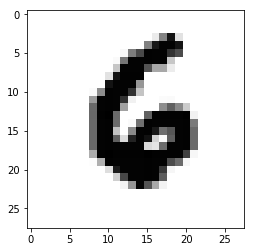

In [35]:
# 실제 그림을 잘 맞추는지 한 숫자를 랜덤으로 불러와 테스트 해본다
r = random.randint(0, mnist.test.num_examples -1)
print ("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r+1], 1)))
print ("Prediction: ", sess.run(tf.argmax(activation, 1), {x:mnist.test.images[r:r+1]}))

plt.imshow(mnist.test.images[r:r+1].reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()